<a href="https://colab.research.google.com/github/jinhyung426/deeplearning.ai/blob/main/tf_chap2_cnn_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Part 2. Convolutional Neural Networks in TensorFlow

## (2) Transfer Learning 

**[Characteristics of Transfer Learning]**
  - Faster training, Better accuracy
  - Training data 부족시 사용 가능한 technique
  - Typically lock most of the convolutional layers
  - Can use dropout to prevent over-specialization
  - Can still use image augmentation since newly added DNN is trainable

**[Procedure]**

1. Get a pre_trained_model.h5 file
2. **Instantiate an instance** of pre_trained_model type **with a desired input shape **by using **tensorflow.keras.applications** with input_shape, include_top, weights
3. **Load the weights by using 'load_weights(pre_trained_model.h5)**


       from tensorflow.keras.applications.inception_v3 import InceptionV3

       local_weights_file = '/tmp/    inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

       pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                        include_top = False, 
                                        weights = None)

       pre_trained_model.load_weights(local_weights_file)

4. **Use summary()** to look at the overall structure
5. **Lock the convolutional layers** to prevent them from being retrained

  - Typical to lock all the convolutional layers and modify the classifiers(DNN) but sometimes modify the last few layers since it may be too specialized
    
    ex) Convolutions from other model may extract features that may not be extractable from your own custom data


    for layer in pre_trained_model.layers:
		   layer.trainable = False

6. **Select the last layer** by using the layer name from the summary and using **'get_layer'**
   
       last_layer = pre_trained_model.get_layer('mixed7')

7. **Connect** the last layer **with your custom DNN** which will be retrained
   
       last_output = last_layer.output
       new_last_output = Dense(1, activation='relu')(last_output)
       model = Model(inputs=pre_trained_model.input, output=new_last_output)

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-30 15:00:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.2.112, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   241MB/s    in 0.3s    

2021-01-30 15:00:14 (241 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
pre_trained_model = InceptionV3(include_top=False, input_shape=(150, 150, 3), weights=None)

1. **include_top**
   - **False** : **do not include the last FC layer**
   - True : include every layers including the last FC layer
2. **input_shape**
   - Instantiate it with the desired input shape for your custom data
3. **weights=None**
   - **to not use the built-in weights** in the InceptionV3 API but use the weights from another model
   - **parameters will be loaded **into the skeleton of the model by using .**load_weights**(.h5)

In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
net = layers.Flatten()(last_output)
net = layers.Dense(1024, activation='relu')(net)
net = layers.Dropout(0.2)(net)
final_output = layers.Dense(1, activation='sigmoid')(net)
model = Model(inputs=pre_trained_model.input, outputs=final_output)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])


# 아래 내용은 예전 내용과 중복

In [ ]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

--2021-01-30 14:46:43--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   356MB/s    in 0.2s    

2021-01-30 14:46:44 (356 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 - 121s - loss: 0.3582 - accuracy: 0.8600 - val_loss: 0.1810 - val_accuracy: 0.9370
Epoch 2/20
100/100 - 116s - loss: 0.2373 - accuracy: 0.9070 - val_loss: 0.1444 - val_accuracy: 0.9440
Epoch 3/20
100/100 - 115s - loss: 0.1860 - accuracy: 0.9275 - val_loss: 0.1001 - val_ac

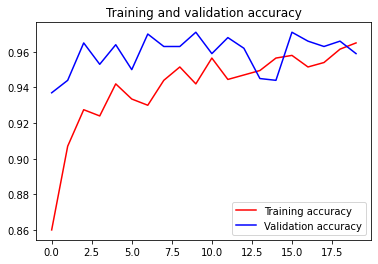

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()